In [5]:
""" 
Steps to get model running and generate attention maps
1. (DONE) Load model weights from checkpoint following script example for MolOR; verify layers initialized correctly
2. (DONE) Load example protein sequence and ligand SMILES string, convert into batch of graphs and ESM embeddings
3. (DONE) Implement custom method to just grab batch of attention weights and save to tensor, custom method in MolOR as well.
4. Run model on batch of graphs and embeddings, save attention weights to tensor
"""

' \nSteps to get model running and generate attention maps\n1. (DONE) Load model weights from checkpoint following script example for MolOR; verify layers initialized correctly\n2. (DONE) Load example protein sequence and ligand SMILES string, convert into batch of graphs and ESM embeddings\n3. (DONE) Implement custom method to just grab batch of attention weights and save to tensor, custom method in MolOR as well.\n4. Run model on batch of graphs and embeddings, save attention weights to tensor\n'

In [1]:
import numpy as np
import torch
import torch.nn as nn

from dgllife.model import load_pretrained
from dgllife.utils import EarlyStopping, Meter, SMILESToBigraph
from torch.optim import Adam
from torch.utils.data import DataLoader
import numpy as np

from utils import collate_molgraphs, load_model, predict, predict_OR_feat
from utils import init_featurizer, mkdir_p, split_dataset, get_configure


### Load model checkpoint 

In [2]:
args = {}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda:0')
else:
    args['device'] = torch.device('cpu')
args['model'] = 'MolOR'
args['featurizer_type'] = 'canonical'
args['dataset'] = 'M2OR_Pairs'
args['cross_attention'] = True
args['sample_weight'] = False
args['esm_random_weights'] = False
args['esm_version'] = '650m'
args['num_workers'] = 0
args = init_featurizer(args)

from data.m2or import M2OR_Pairs
## TODO : REMOVE MAX NODE LEN = 100
smiles_to_g = SMILESToBigraph(add_self_loop=True, node_featurizer=args['node_featurizer'],
                                edge_featurizer=args['edge_featurizer'])

"""
dataset = M2OR_Pairs(smiles_to_graph=smiles_to_g, weighted_samples=args['sample_weight'],
                    cross_attention=args['cross_attention'], load_full=True, 
                    esm_random_weights=args['esm_random_weights'], esm_model=args['esm_version'],
                    n_jobs=1 if args['num_workers'] == 0 else args['num_workers'])#, max_node_len=100)            
args['max_seq_len'] = dataset.max_seq_len
args['max_node_len'] = dataset.max_node_len

"""

exp_config = get_configure(args['model'], args['featurizer_type'], args['dataset'])
#exp_config['device'] = args['device']
#exp_config['model'] = args['model']
#exp_config['featurizer_type'] = args['featurizer_type']
#exp_config['dataset'] = args['dataset']

#model.load_state_dict(OR_checkpoint['model_state_dict'])


/home/seyonec/olfaction/data/configures/M2OR_Pairs/MolOR_canonical.json
{'lr': 0.02, 'weight_decay': 0, 'patience': 30, 'batch_size': 128, 'dropout': 0.05, 'gnn_hidden_feats': 256, 'predictor_hidden_feats': 128, 'num_gnn_layers': 2, 'residual': True, 'batchnorm': False}


In [36]:
propionate = 'CCC([O-])=O'
or51e2 = "DYKDDDDASIDSSCNFTHATFVLIGIPGLEKAHFWVGFPLLSMYVVAMFGNCIVVFIVRTERSLHAPMYLFLCMLAAIDLALSTSTMPKILALFWFDSREISFEACLTQMFFIHALSAIESTILLAMAFDRYVAICHPLRHAAVLNNTVTAQIGIVAVVRGSLFFFPLPLLIKRLAFCHSNVLSHSYCVHQDVMKLAYADTLPNVVYGLTAILLVMGVDVMFISLSYFLIIRTVLQLPSKSERAKAFGTCVSHIGVVLAFYVPLIGLSVVHRFGNSLHPIVRVVMGDIYLLLPPVINPIIYGAKTKQIRTRVLAMFKISCDKDLQAVGGK"

#"""MSSCNFTHATFVLIGIPGLEKAHFWVGFPLLSMYVVAMFGNCIVVFIVRTERSLHAPMYLFLCMLAAIDLALSTSTMPKILALFWFDSREISFEACLTQMFFIHALSAIESTILLAMAFDRYVAICHPLRHAAVLNNTVTAQIGIVAVVRGSLFFFPLPLLIKRLAFCHSNVLSHSYCVHQDVMKLAYADTLPNVVYGLTAILLVMGVDVMFISLSYFLIIRTVLQLPSKSERAKAFGTCVSHIGVVLAFYVPLIGLSVVHRFGNSLHPIVRVVMGDIYLLLPPVINPIIYGAKTKQIRTRVLAMFKISCDKDLQAVGGK""" 
## Source: Uniprot


#mol = 'CC1=CCC(CC1)C(=C)C' #limonene
## Q9P1Q5 - OR1A1
#protein = 'MRENNQSSTLEFILLGVTGQQEQEDFFYILFLFIYPITLIGNLLIVLAICSDVRLHNPMYFLLANLSLVDIFFSSVTIPKMLANHLLGSKSISFGGCLTQMYFMIALGNTDSYILAAMAYDRAVAISRPLHYTTIMSPRSCIWLIAGSWVIGNANALPHTLLTASLSFCGNQEVANFYCDITPLLKLSCSDIHFHVKMMYLGVGIFSVPLLCIIVSYIRVFSTVFQVPSTKGVLKAFSTCGSHLTVVSLYYGTVMGTYFRPLTNYSLKDAVITVMYTAVTPMLNPFIYSLRNRDMKAALRKLFNKRISS'
OR_seqs = []
odorants = []
#OR_seqs.append(protein)
#odorants.append(mol)
OR_seqs.append(or51e2)
odorants.append(propionate)

## pad based on max_seq_len
max_seq_len = len(max(OR_seqs, key=len))        
seq_masks = torch.zeros((len(OR_seqs), max_seq_len))
print(len(seq_masks))
print(seq_masks.shape)
for i in range(len(OR_seqs)):
    seq_masks[i, :len(OR_seqs[i])] = 1
    OR_seqs[i] += "<pad>"*(max_seq_len - len(OR_seqs[i]))
exp_config['max_seq_len'] = max_seq_len
from data.m2or import esm_embed
seq_embeddings = esm_embed(OR_seqs, per_residue=True, random_weights=False, esm_model_version = '650m') ## output shape: (100, max_seq_len, embedding_dim)
print(len(seq_embeddings))#.shape)
seq_emb_arr = np.dstack(seq_embeddings)
seq_embeddings = torch.FloatTensor(np.rollaxis(seq_emb_arr, -1))#.cuda()
print(seq_embeddings.shape)



1
torch.Size([1, 330])
done embedding sequences
1
torch.Size([1, 330, 1280])


In [37]:
from dgl import batch
graphs = []
for odorant in odorants:
    g = smiles_to_g(odorant)
    g = g.to(args['device'])
    graphs.append(g)
batched_graphs = batch(graphs)

## define node mask for set of ligands provided
max_node_len = max([g.number_of_nodes() for g in graphs])

graph_mask = torch.zeros((len(graphs), max_node_len))
for idx in range(len(graphs)):
    graph_mask[idx, :graphs[idx].num_nodes()] = 1


In [38]:
args['n_tasks'] = 1 #dataset.n_tasks
exp_config['add_feat_size'] = 1280
exp_config['mol2prot_dim'] = True
exp_config['max_seq_len'] = max_seq_len
exp_config['max_node_len'] = max_node_len

##TODO: Change model path accordingly
#args['prev_model_path'] = 'm2or_cross_attention_fixed_dimension_batch_size_128'
args['prev_model_path'] = 'm2or_cross_attention_90_10_0_fixed_dimension_batch_size_128'

if args['featurizer_type'] != 'pre_train':
    print(exp_config)
    print(args['node_featurizer'].feat_size())
    exp_config['in_node_feats'] = args['node_featurizer'].feat_size()
    if args['edge_featurizer'] is not None:
        exp_config['in_edge_feats'] = args['edge_featurizer'].feat_size()
exp_config.update({
    'n_tasks': args['n_tasks'],
    'model': args['model']
})

model = load_model(exp_config).to(args['device'])
OR_checkpoint = torch.load(args['prev_model_path'] + '/model.pth', map_location=args['device'])
model.load_state_dict(OR_checkpoint['model_state_dict'])
model.eval()


{'lr': 0.02, 'weight_decay': 0, 'patience': 30, 'batch_size': 128, 'dropout': 0.05, 'gnn_hidden_feats': 256, 'predictor_hidden_feats': 128, 'num_gnn_layers': 2, 'residual': True, 'batchnorm': False, 'max_seq_len': 330, 'add_feat_size': 1280, 'mol2prot_dim': True, 'max_node_len': 5, 'in_node_feats': 74, 'n_tasks': 1, 'model': 'MolOR'}
74


MolORPredictor(
  (gnn): GCN(
    (gnn_layers): ModuleList(
      (0): GCNLayer(
        (graph_conv): GraphConv(in=74, out=256, normalization=none, activation=<function relu at 0x7fbc59d9e8b0>)
        (dropout): Dropout(p=0.05, inplace=False)
        (res_connection): Linear(in_features=74, out_features=256, bias=True)
      )
      (1): GCNLayer(
        (graph_conv): GraphConv(in=256, out=256, normalization=none, activation=<function relu at 0x7fbc59d9e8b0>)
        (dropout): Dropout(p=0.05, inplace=False)
        (res_connection): Linear(in_features=256, out_features=256, bias=True)
      )
    )
  )
  (readout): WeightedSumAndMax(
    (weight_and_sum): WeightAndSum(
      (atom_weighting): Sequential(
        (0): Linear(in_features=256, out_features=1, bias=True)
        (1): Sigmoid()
      )
    )
  )
  (cross_attn): CrossAttention_2(
    (query_transform_tensor1): Linear(in_features=1280, out_features=1280, bias=True)
    (key_transform_tensor1): Linear(in_features=1280, out

In [39]:
model.cross_attn

CrossAttention_2(
  (query_transform_tensor1): Linear(in_features=1280, out_features=1280, bias=True)
  (key_transform_tensor1): Linear(in_features=1280, out_features=1280, bias=True)
  (value_transform_tensor1): Linear(in_features=1280, out_features=1280, bias=True)
  (query_transform_tensor2): Linear(in_features=256, out_features=1280, bias=True)
  (key_transform_tensor2): Linear(in_features=256, out_features=1280, bias=True)
  (value_transform_tensor2): Linear(in_features=256, out_features=1280, bias=True)
  (linear1): Linear(in_features=1280, out_features=1, bias=True)
  (linear2): Linear(in_features=1280, out_features=1, bias=True)
)

In [40]:
node_feats = batched_graphs.ndata.pop('h').to(args['device'])

seq_masks = seq_masks.to(args['device'])
graph_mask = graph_mask.to(args['device'])

# prot_attention_maps: query is protein, key is ligand
# mol_attention_maps: query is ligand, key is protein
with torch.no_grad():
    prot_attention_maps, mol_attention_maps = model.generate_attention_maps(bg=batched_graphs, feats=node_feats, add_feats=seq_embeddings, node_mask=graph_mask, seq_mask=seq_masks)

In [41]:
mol_attention_maps.shape

torch.Size([1, 5, 330])

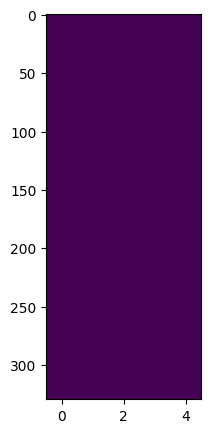

In [42]:
import matplotlib.pyplot as plt

## view attention maps for both, have each column's length (num of pixels) be increased
fig, ax = plt.subplots(figsize=(2, 5))
ax.imshow(prot_attention_maps[0].cpu().numpy(), interpolation='nearest')
ax.set_aspect('auto')
plt.show()

#plt.imshow(prot_attention_maps[0].cpu().numpy(), cmap='hot', interpolation='nearest')


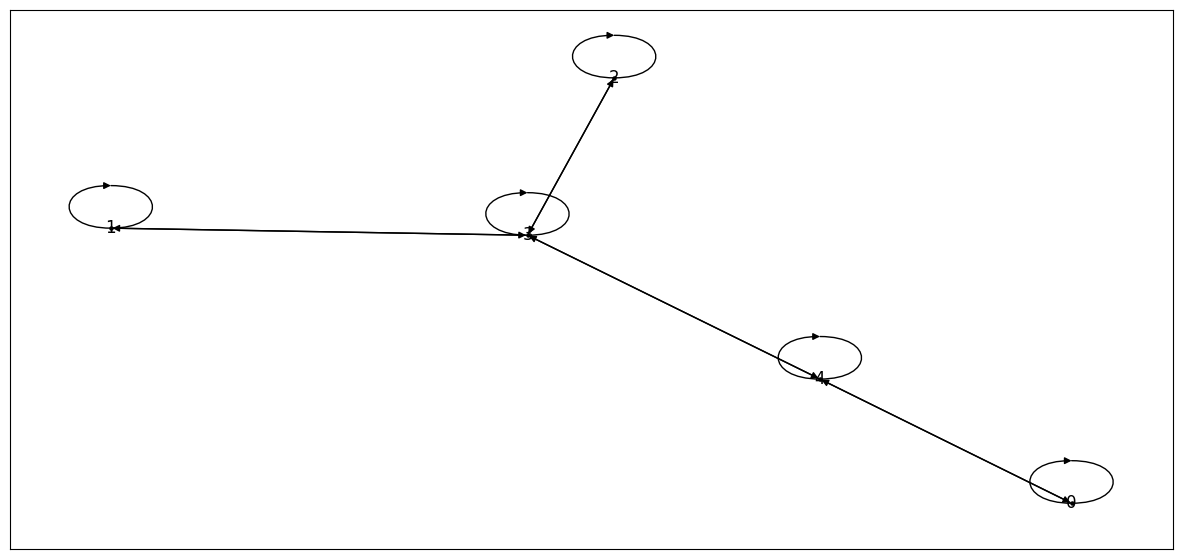

In [43]:
import networkx as nx
import dgl
g = graphs[0].cpu()
options = {
    'node_color': 'black',
    'node_size': 5,
    'width': 1,
}
G = dgl.to_networkx(g)
plt.figure(figsize=[15,7])
nx.draw_networkx(G, **options)
#mol = 'CC1=CCC(CC1)C(=C)C'


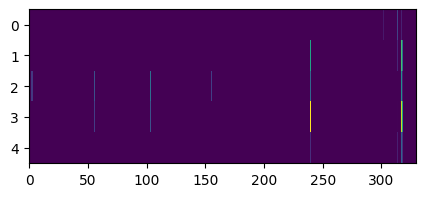

In [44]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.imshow(mol_attention_maps[0].cpu().numpy(), interpolation='nearest')
ax.set_aspect('auto')
plt.show()


In [45]:
## Check if any values > 0 in mol_attention_maps
mol_attention_maps[0].cpu().numpy().max()

26109212.0

In [46]:
## find columns of mol_attention_maps that have values > 0
## get indices of non-zero argmax
mol_attention_maps[0].cpu().numpy().argmax(axis=0).nonzero()

(array([  2,  55, 103, 155, 239, 316, 317]),)

In [49]:
OR_seqs[0][103]

'E'

In [48]:
seq = """MSSCNFTHATFVLIGIPGLEKAHFWVGFPLLSMYVVAMFGNCIVVFIVRTERSLHAPMYL
FLCMLAAIDLALSTSTMPKILALFWFDSREISFEACLTQMFFIHALSAIESTILLAMAFD
RYVAICHPLRHAAVLNNTVTAQIGIVAVVRGSLFFFPLPLLIKRLAFCHSNVLSHSYCVH
QDVMKLAYADTLPNVVYGLTAILLVMGVDVMFISLSYFLIIRTVLQLPSKSERAKAFGTC
VSHIGVVLAFYVPLIGLSVVHRFGNSLHPIVRVVMGDIYLLLPPVINPIIYGAKTKQIRT
RVLAMFKISCDKDLQAVGGK"""
seq[103]



'I'